**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [10]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [28]:
from packaging import version
import tensorflow as tf
import numpy as np

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [12]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/deep` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [13]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [14]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

4422102/4422102 [==============================] - 1s 0us/step


In [15]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [16]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

# Batch Normalization

In [17]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [20]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [21]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5533 - accuracy: 0.8079 - val_loss: 0.3979 - val_accuracy: 0.8544
Epoch 2/2
1719/1719 [==============================] - 11s 7ms/step - loss: 0.4061 - accuracy: 0.8547 - val_loss: 0.3569 - val_accuracy: 0.8670


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [22]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [24]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6026 - accuracy: 0.7964 - val_loss: 0.4307 - val_accuracy: 0.8458
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4294 - accuracy: 0.8489 - val_loss: 0.3771 - val_accuracy: 0.8600


## Gradient Clipping

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [25]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [26]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [29]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 5s 3ms/step - loss: 1.3494 - accuracy: 0.5677 - val_loss: 0.8033 - val_accuracy: 0.7275
Epoch 2/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.6800 - accuracy: 0.7635 - val_loss: 0.5785 - val_accuracy: 0.7907
Epoch 3/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.5378 - accuracy: 0.8228 - val_loss: 0.4875 - val_accuracy: 0.8335
Epoch 4/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4638 - accuracy: 0.8495 - val_loss: 0.4314 - val_accuracy: 0.8561
Epoch 5/20
1376/1376 [==============================] - 5s 4ms/step - loss: 0.4163 - accuracy: 0.8644 - val_loss: 0.3944 - val_accuracy: 0.8691
Epoch 6/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3825 - accuracy: 0.8733 - val_loss: 0.3695 - val_accuracy: 0.8739
Epoch 7/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3588 - accuracy: 0.8796 - val_loss: 0.3508 - val_accuracy:

In [30]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 43ms/step - loss: 0.6269 - accuracy: 0.5950 - val_loss: 0.6207 - val_accuracy: 0.5945
Epoch 2/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6040 - accuracy: 0.6350 - val_loss: 0.6019 - val_accuracy: 0.6647
Epoch 3/20
7/7 [==============================] - 0s 17ms/step - loss: 0.5867 - accuracy: 0.7000 - val_loss: 0.5872 - val_accuracy: 0.7211
Epoch 4/20
7/7 [==============================] - 0s 16ms/step - loss: 0.5708 - accuracy: 0.7800 - val_loss: 0.5733 - val_accuracy: 0.7705
Epoch 5/20
7/7 [==============================] - 0s 31ms/step - loss: 0.5569 - accuracy: 0.8200 - val_loss: 0.5594 - val_accuracy: 0.8289
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 0.5429 - accuracy: 0.8550 - val_loss: 0.5463 - val_accuracy: 0.8546
Epoch 7/20
7/7 [==============================] - 0s 17ms/step - loss: 0.5296 - accuracy: 0.8750 - val_loss: 0.5341 - val_accuracy: 0.8853
Epoch 8/20
7/7 [===========

[0.4309276342391968, 0.9235000014305115]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [31]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [32]:
tf.random.set_seed(42)  # extra code – ensure reproducibility

In [33]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [34]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [35]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

In [36]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 45ms/step - loss: 3.7649 - accuracy: 0.4450 - val_loss: 3.0038 - val_accuracy: 0.4847
Epoch 2/4
7/7 [==============================] - 0s 17ms/step - loss: 2.8225 - accuracy: 0.4450 - val_loss: 2.1217 - val_accuracy: 0.4847
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 1.9018 - accuracy: 0.4450 - val_loss: 1.2631 - val_accuracy: 0.4847
Epoch 4/4
7/7 [==============================] - 0s 16ms/step - loss: 1.0805 - accuracy: 0.4450 - val_loss: 0.7579 - val_accuracy: 0.4876
Epoch 1/16
7/7 [==============================] - 1s 43ms/step - loss: 0.6406 - accuracy: 0.6050 - val_loss: 0.5618 - val_accuracy: 0.7478
Epoch 2/16
7/7 [==============================] - 0s 17ms/step - loss: 0.5358 - accuracy: 0.8350 - val_loss: 0.5150 - val_accuracy: 0.8566
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.4922 - accuracy: 0.8900 - val_loss: 0.4895 - val_accuracy: 0.8734
Epoch 4/16
7/7 [===============

So, what's the final verdict?

In [37]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.3097 - accuracy: 0.9275


[0.30965864658355713, 0.9275000095367432]

Great! We got a bit of transfer: the model's accuracy went up 2 percentage points, from 91.85% to 93.85%. This means the error rate dropped by almost 25%:

In [38]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

# Faster Optimizers

In [39]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [40]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [41]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7046 - accuracy: 0.7618 - val_loss: 0.5088 - val_accuracy: 0.8172
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4701 - accuracy: 0.8363 - val_loss: 0.4534 - val_accuracy: 0.8342
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4246 - accuracy: 0.8503 - val_loss: 0.4102 - val_accuracy: 0.8562
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3969 - accuracy: 0.8595 - val_loss: 0.3836 - val_accuracy: 0.8638
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3749 - accuracy: 0.8671 - val_loss: 0.3697 - val_accuracy: 0.8680
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3612 - accuracy: 0.8709 - val_loss: 0.3691 - val_accuracy: 0.8660
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3448 - accuracy: 0.8756 - val_loss: 0.3630 - val_accuracy:

## Momentum optimization

In [42]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [43]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7020 - accuracy: 0.7612 - val_loss: 0.5094 - val_accuracy: 0.8180
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4671 - accuracy: 0.8371 - val_loss: 0.4466 - val_accuracy: 0.8408
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4217 - accuracy: 0.8522 - val_loss: 0.4154 - val_accuracy: 0.8536
Epoch 4/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3943 - accuracy: 0.8603 - val_loss: 0.3866 - val_accuracy: 0.8606
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3718 - accuracy: 0.8674 - val_loss: 0.3691 - val_accuracy: 0.8664
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3590 - accuracy: 0.8726 - val_loss: 0.3745 - val_accuracy: 0.8658
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3435 - accuracy: 0.8750 - val_loss: 0.3740 - val_accuracy:

## Nesterov Accelerated Gradient

In [44]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [45]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6884 - accuracy: 0.7653 - val_loss: 0.4842 - val_accuracy: 0.8322
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4626 - accuracy: 0.8367 - val_loss: 0.4404 - val_accuracy: 0.8412
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4209 - accuracy: 0.8515 - val_loss: 0.4043 - val_accuracy: 0.8570
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3960 - accuracy: 0.8612 - val_loss: 0.3848 - val_accuracy: 0.8636
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3751 - accuracy: 0.8681 - val_loss: 0.3787 - val_accuracy: 0.8626
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3614 - accuracy: 0.8719 - val_loss: 0.3741 - val_accuracy: 0.8664
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3461 - accuracy: 0.8759 - val_loss: 0.3764 - val_accuracy:

## AdaGrad

In [46]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [47]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 1.0230 - accuracy: 0.6718 - val_loss: 0.7105 - val_accuracy: 0.7644
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6629 - accuracy: 0.7767 - val_loss: 0.6061 - val_accuracy: 0.7952
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5918 - accuracy: 0.8015 - val_loss: 0.5582 - val_accuracy: 0.8124
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5540 - accuracy: 0.8144 - val_loss: 0.5303 - val_accuracy: 0.8182
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5287 - accuracy: 0.8211 - val_loss: 0.5102 - val_accuracy: 0.8226
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5103 - accuracy: 0.8270 - val_loss: 0.4978 - val_accuracy: 0.8286
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4964 - accuracy: 0.8307 - val_loss: 0.4832 - val_accuracy:

## RMSProp

In [48]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [49]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5176 - accuracy: 0.8138 - val_loss: 0.4223 - val_accuracy: 0.8438
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3896 - accuracy: 0.8602 - val_loss: 0.4199 - val_accuracy: 0.8478
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3655 - accuracy: 0.8697 - val_loss: 0.4138 - val_accuracy: 0.8614
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3563 - accuracy: 0.8744 - val_loss: 0.4068 - val_accuracy: 0.8680
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3500 - accuracy: 0.8775 - val_loss: 0.3916 - val_accuracy: 0.8664
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3486 - accuracy: 0.8792 - val_loss: 0.4297 - val_accuracy: 0.8570
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3486 - accuracy: 0.8790 - val_loss: 0.4259 - val_accuracy:

## Adam Optimization

In [50]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                     beta_2=0.999)

In [51]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4978 - accuracy: 0.8208 - val_loss: 0.4069 - val_accuracy: 0.8454
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3786 - accuracy: 0.8615 - val_loss: 0.3897 - val_accuracy: 0.8496
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3442 - accuracy: 0.8731 - val_loss: 0.3442 - val_accuracy: 0.8724
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3192 - accuracy: 0.8817 - val_loss: 0.3355 - val_accuracy: 0.8778
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2997 - accuracy: 0.8879 - val_loss: 0.3393 - val_accuracy: 0.8722
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2862 - accuracy: 0.8920 - val_loss: 0.3447 - val_accuracy: 0.8788
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2740 - accuracy: 0.8968 - val_loss: 0.3580 - val_accuracy:

**Adamax Optimization**

In [52]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                       beta_2=0.999)

In [53]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5293 - accuracy: 0.8164 - val_loss: 0.4327 - val_accuracy: 0.8402
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3960 - accuracy: 0.8582 - val_loss: 0.3876 - val_accuracy: 0.8616
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3600 - accuracy: 0.8713 - val_loss: 0.3668 - val_accuracy: 0.8704
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3355 - accuracy: 0.8785 - val_loss: 0.3444 - val_accuracy: 0.8764
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3159 - accuracy: 0.8848 - val_loss: 0.3303 - val_accuracy: 0.8768
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3021 - accuracy: 0.8885 - val_loss: 0.3375 - val_accuracy: 0.8758
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2886 - accuracy: 0.8938 - val_loss: 0.3306 - val_accuracy:

**Nadam Optimization**

In [54]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [55]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.4850 - accuracy: 0.8264 - val_loss: 0.3897 - val_accuracy: 0.8530
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3685 - accuracy: 0.8656 - val_loss: 0.3709 - val_accuracy: 0.8558
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3344 - accuracy: 0.8783 - val_loss: 0.3325 - val_accuracy: 0.8790
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3117 - accuracy: 0.8857 - val_loss: 0.3396 - val_accuracy: 0.8752
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2959 - accuracy: 0.8904 - val_loss: 0.3256 - val_accuracy: 0.8796
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2803 - accuracy: 0.8953 - val_loss: 0.3384 - val_accuracy: 0.8748
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2683 - accuracy: 0.8981 - val_loss: 0.3461 - val_accuracy

**AdamW Optimization**

On Colab or Kaggle, we need to install the TensorFlow-Addons library:

In [56]:
if "google.colab" in sys.modules:
    %pip install -q -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.2 MB/s eta 0:00:00


In [57]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [58]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.4992 - accuracy: 0.8204 - val_loss: 0.4245 - val_accuracy: 0.8326
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3759 - accuracy: 0.8633 - val_loss: 0.3906 - val_accuracy: 0.8484
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3420 - accuracy: 0.8749 - val_loss: 0.3485 - val_accuracy: 0.8720
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3173 - accuracy: 0.8840 - val_loss: 0.3478 - val_accuracy: 0.8748
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3002 - accuracy: 0.8891 - val_loss: 0.3219 - val_accuracy: 0.8818
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2862 - accuracy: 0.8942 - val_loss: 0.3353 - val_accuracy: 0.8788
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2759 - accuracy: 0.8967 - val_loss: 0.3499 - val_accura

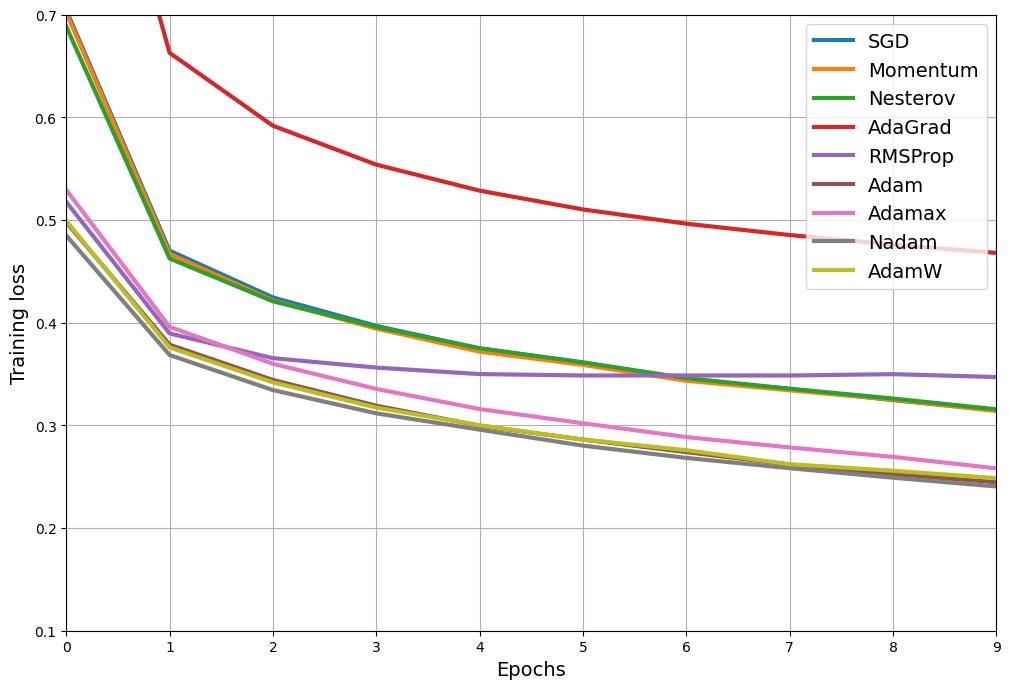

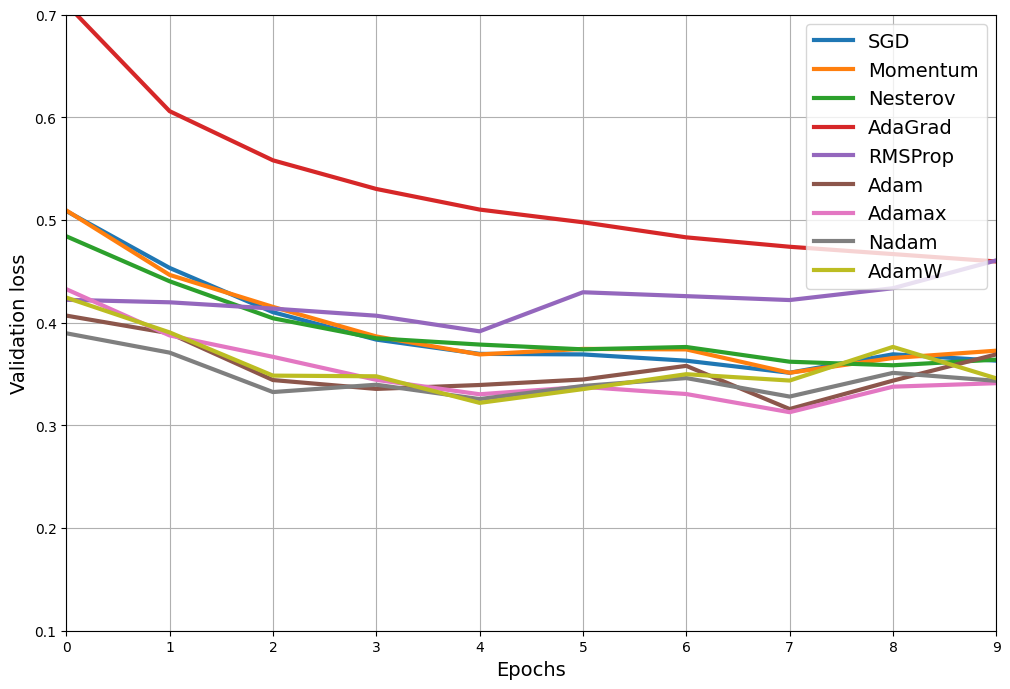

In [62]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper right")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / weight_decay`

In [63]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-4)

In [64]:
history_power_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7066 - accuracy: 0.7548 - val_loss: 0.4731 - val_accuracy: 0.8268
Epoch 2/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4754 - accuracy: 0.8305 - val_loss: 0.4592 - val_accuracy: 0.8308
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4276 - accuracy: 0.8464 - val_loss: 0.4245 - val_accuracy: 0.8494
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4017 - accuracy: 0.8571 - val_loss: 0.3839 - val_accuracy: 0.8614
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3814 - accuracy: 0.8634 - val_loss: 0.3721 - val_accuracy: 0.8626
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3644 - accuracy: 0.8687 - val_loss: 0.3803 - val_accuracy: 0.8640
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3532 - accuracy: 0.8706 - val_loss: 0.3606 - val_accuracy:

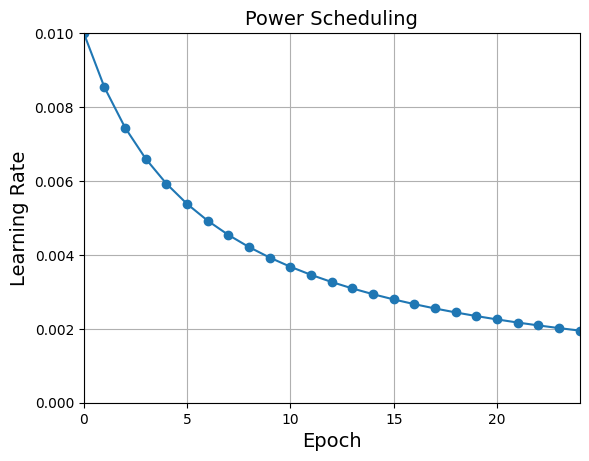

In [65]:
# extra code – this cell plots power scheduling

import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1 ** (epoch / s)```

In [66]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [67]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [68]:
# extra code – build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [69]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6958 - accuracy: 0.7632 - val_loss: 0.4887 - val_accuracy: 0.8270 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4703 - accuracy: 0.8346 - val_loss: 0.4530 - val_accuracy: 0.8368 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4240 - accuracy: 0.8500 - val_loss: 0.4183 - val_accuracy: 0.8548 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4005 - accuracy: 0.8587 - val_loss: 0.3935 - val_accuracy: 0.8588 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3809 - accuracy: 0.8650 - val_loss: 0.3870 - val_accuracy: 0.8598 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3666 - accuracy: 0.8702 - val_loss: 0.3868 - val_accuracy: 0.8642 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 6s

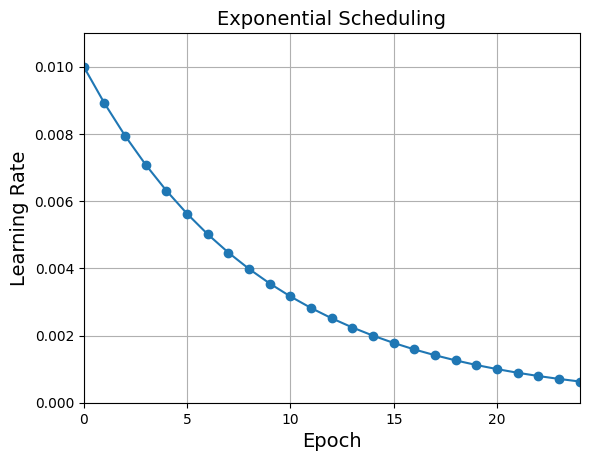

In [70]:
# extra code – this cell plots exponential scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [71]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

**Extra material**: if you want to update the learning rate at each iteration rather than at each epoch, you can write your own callback class:

In [72]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [73]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [74]:
n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.6955 - accuracy: 0.7594 - val_loss: 0.4946 - val_accuracy: 0.8242 - lr: 0.0091
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4726 - accuracy: 0.8338 - val_loss: 0.4568 - val_accuracy: 0.8350 - lr: 0.0083
Epoch 3/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4250 - accuracy: 0.8476 - val_loss: 0.4148 - val_accuracy: 0.8524 - lr: 0.0076
Epoch 4/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4011 - accuracy: 0.8578 - val_loss: 0.3874 - val_accuracy: 0.8600 - lr: 0.0069
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3819 - accuracy: 0.8632 - val_loss: 0.3807 - val_accuracy: 0.8650 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3666 - accuracy: 0.8692 - val_loss: 0.3902 - val_accuracy: 0.8634 - lr: 0.0058
Epoch 7/25
1719/1719 [==============================] - 7s

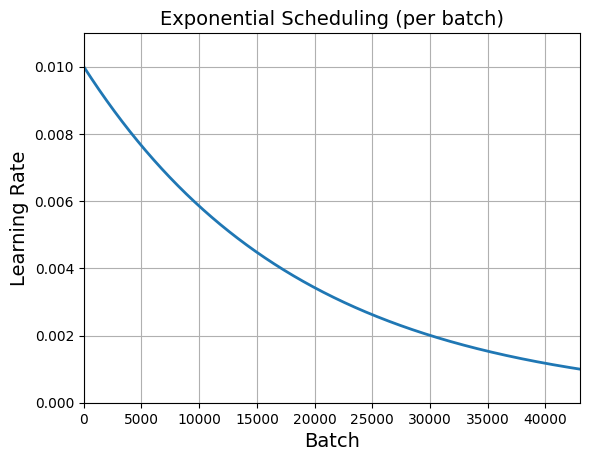

In [75]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [76]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [77]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [78]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 11s 5ms/step - loss: 0.5463 - accuracy: 0.8047 - val_loss: 0.4575 - val_accuracy: 0.8344 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4538 - accuracy: 0.8412 - val_loss: 0.4571 - val_accuracy: 0.8348 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4279 - accuracy: 0.8483 - val_loss: 0.4349 - val_accuracy: 0.8468 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4247 - accuracy: 0.8518 - val_loss: 0.4365 - val_accuracy: 0.8520 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4106 - accuracy: 0.8561 - val_loss: 0.4511 - val_accuracy: 0.8432 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3568 - accuracy: 0.8711 - val_loss: 0.3939 - val_accuracy: 0.8588 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 9

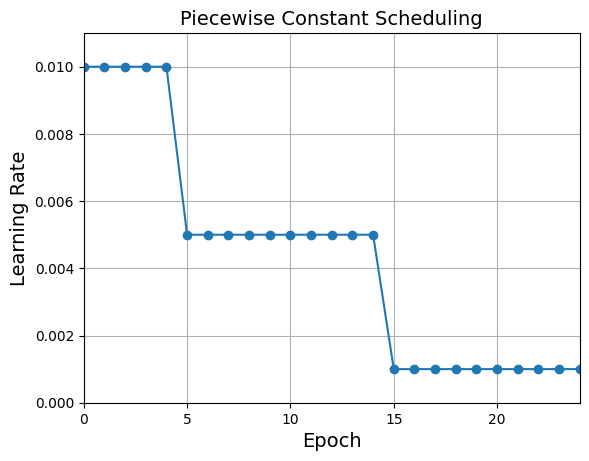

In [79]:
# extra code – this cell plots piecewise constant scheduling

plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [80]:
# extra code – build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [81]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6919 - accuracy: 0.7652 - val_loss: 0.4781 - val_accuracy: 0.8296 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4647 - accuracy: 0.8353 - val_loss: 0.4287 - val_accuracy: 0.8438 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4163 - accuracy: 0.8516 - val_loss: 0.4050 - val_accuracy: 0.8594 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3922 - accuracy: 0.8594 - val_loss: 0.3722 - val_accuracy: 0.8650 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3728 - accuracy: 0.8668 - val_loss: 0.3657 - val_accuracy: 0.8714 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3561 - accuracy: 0.8725 - val_loss: 0.3870 - val_accuracy: 0.8684 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 5s

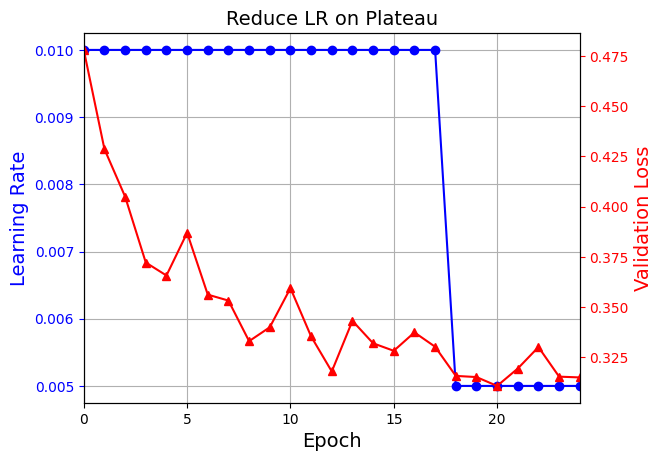

In [82]:
# extra code – this cell plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [83]:
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

In [84]:
# extra code – build and train the model
model = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6756 - accuracy: 0.7709 - val_loss: 0.4836 - val_accuracy: 0.8276
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4670 - accuracy: 0.8357 - val_loss: 0.4467 - val_accuracy: 0.8372
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4220 - accuracy: 0.8507 - val_loss: 0.4203 - val_accuracy: 0.8480
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3990 - accuracy: 0.8597 - val_loss: 0.3874 - val_accuracy: 0.8588
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3793 - accuracy: 0.8663 - val_loss: 0.3826 - val_accuracy: 0.8622
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3652 - accuracy: 0.8704 - val_loss: 0.3922 - val_accuracy: 0.8608
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3540 - accuracy: 0.8739 - val_loss: 0.3707 - val_accuracy:

For piecewise constant scheduling, try this:

In [85]:
# extra code – shows how to use PiecewiseConstantDecay
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [86]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [87]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [88]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [89]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 4s 6ms/step - loss: 1.9220 - accuracy: 0.3945


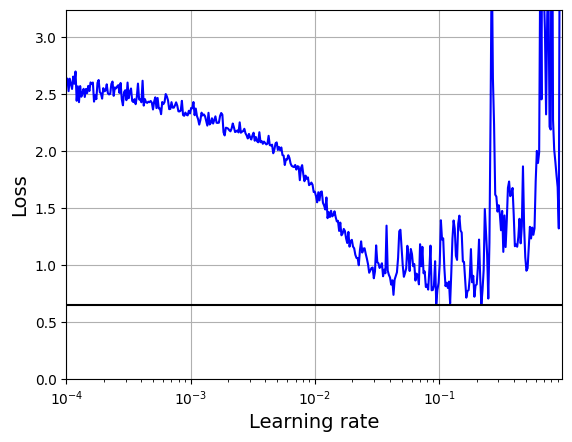

In [90]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning rate to use for 1cycle is around 10<sup>–1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [91]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [92]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 3s 5ms/step - loss: 0.9928 - accuracy: 0.6841 - val_loss: 0.6045 - val_accuracy: 0.7984
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.5709 - accuracy: 0.8009 - val_loss: 0.4987 - val_accuracy: 0.8274
Epoch 3/25
430/430 [==============================] - 2s 6ms/step - loss: 0.4938 - accuracy: 0.8254 - val_loss: 0.4691 - val_accuracy: 0.8352
Epoch 4/25
430/430 [==============================] - 3s 6ms/step - loss: 0.4489 - accuracy: 0.8405 - val_loss: 0.4404 - val_accuracy: 0.8426
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.4213 - accuracy: 0.8489 - val_loss: 0.4219 - val_accuracy: 0.8452
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3952 - accuracy: 0.8570 - val_loss: 0.4906 - val_accuracy: 0.8280
Epoch 7/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3818 - accuracy: 0.8607 - val_loss: 0.3850 - val_accuracy: 0.8602
Epoch 